# Photometry data preprocessing

This notebook shows methods for preprocessing fiber photometry data. The preprocessing consists of the following steps:

1. Lowpass and median filtering to reduce noise and electrical artifacts.

2. Correction for photobleaching, i.e. the slow decreace in the fluorescence signal as flurophores are degraded by light exposure.  Three different methods are shown (i) highpass filtering with a very low cutoff frequency, (ii) Subtraction of a exponential fit (ii) Subtraction of a polynomial fit.

2. Movement correction.  Movement artifacts are estimated by a linear fit of the movement control channel to the GCaMP signal, then subtracted from the GCaMP signal.

4. Conversion of the signal to dF/F.

Note that different groups do preprocessing differently and there is no universally accepted best practice for how to preprocess photometry data.  The best way to preprocess your data will likely depend on the details of the experimental setup and the questions you want to ask of the data. It is good practice to always visually inspect the raw data and the results of each preprocessing step to make sure they look sensible.  

The data used in this notebook were recorded from dopamine neurons in mouse VTA during a reward guided decision task.  The data were recorded using [pyPhotometry](https://pyphotometry.readthedocs.io) acquisition hardware, using the *two colour time division* acquisition mode with GCaMP6f as the calcium indicator and TdTomato as a movement control channel.

Import the standard python modules needed for the analysis.

In [26]:
import os
import numpy as  np
import pylab as plt
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize

plt.rcParams['figure.figsize'] = [14, 12] # Make default figure size larger.
plt.rcParams['axes.xmargin'] = 0          # Make default margin on x axis zero.

Import the pyPhotometry [data import](https://pyphotometry.readthedocs.io/en/latest/user-guide/importing-data/) module.

In [27]:
from trialexp.process.pyphotometry.utils import import_ppd

Import the data file.

In [28]:
# Server
data_folder = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\pyphotometry\data\reaching_go_spout_bar_nov22'
# Sample local data
data_folder = r'C:\Users\phar0732\Documents\GitHub\trialexp\sample_data\pyphotometry\reaching_go_spout_incr_break2_nov22'
data_filename = 'kms061-2023-02-06-103130.ppd'
data = import_ppd(os.path.join(data_folder, data_filename))


Extract the raw GCaMP and TdTomato signals, session time, and sampling rate.

In [29]:
GCaMP_raw = data['analog_1']
TdTom_raw = data['analog_2']
time_seconds = data['time']/1000
sampling_rate = data['sampling_rate']

# Raw signals

Let's take a look at the raw GCaMP and TdTomato signals.

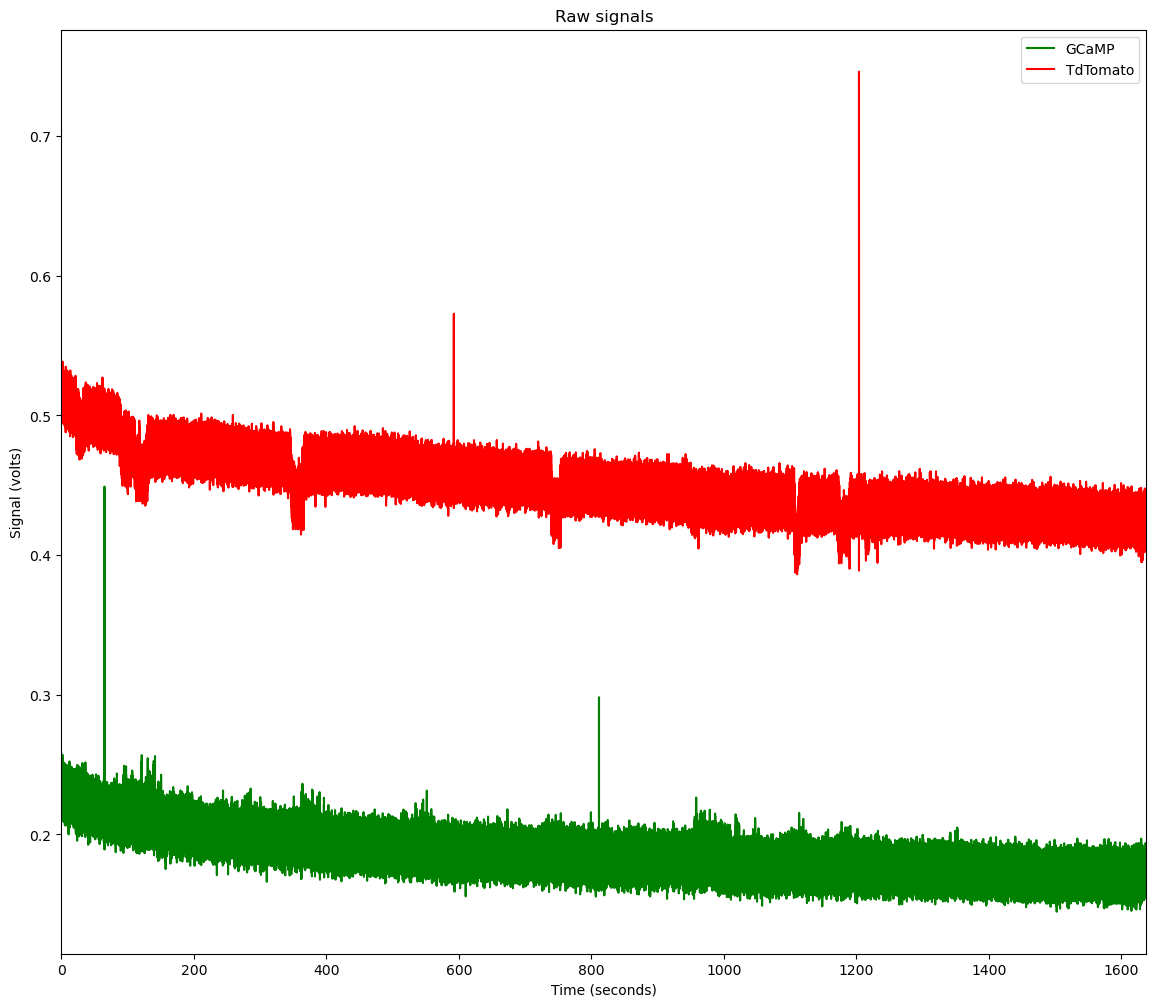

In [30]:
plt.plot(time_seconds, GCaMP_raw, 'g', label='GCaMP')
plt.plot(time_seconds, TdTom_raw, 'r', label='TdTomato')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Raw signals')
plt.legend();

# Denoising

This recording has large electrical noise artifacts, possible due to a nearby MRI machine.  The artifacts are very short pulses and can be greatly reduced by running a median filter before the standard low pass filter.  We then lowpass filter the signals to reduce noise, using a zero phase filter with a 10Hz cutoff frequency.

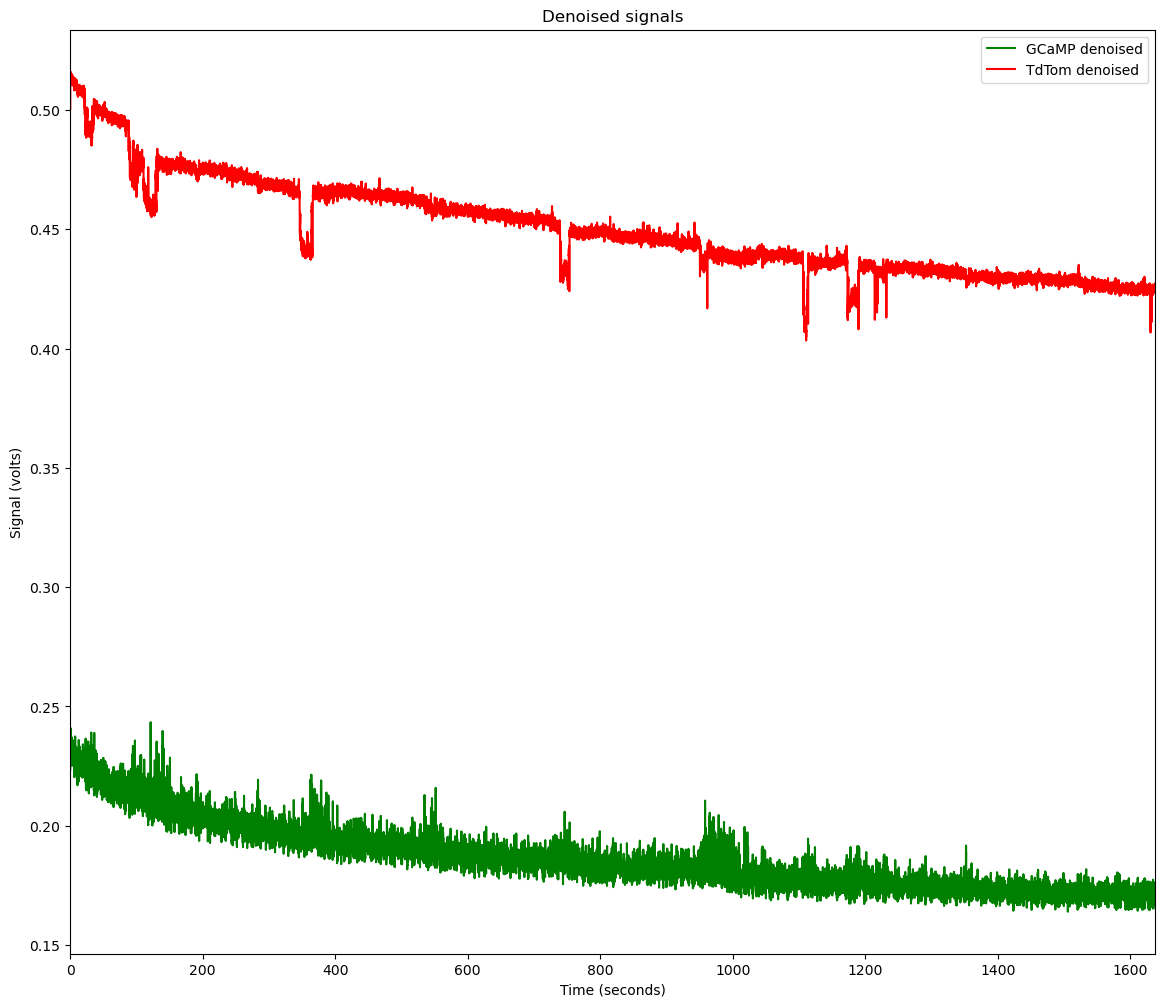

In [31]:
# Median filtering to remove electrical artifact.
GCaMP_denoised = medfilt(GCaMP_raw, kernel_size=5)
TdTom_denoised = medfilt(TdTom_raw, kernel_size=5)
 
# Lowpass filter - zero phase filtering (with filtfilt) is used to avoid distorting the signal.
b,a = butter(2, 10, btype='low', fs=sampling_rate)
GCaMP_denoised = filtfilt(b,a, GCaMP_denoised)
TdTom_denoised = filtfilt(b,a, TdTom_denoised)

#plt.plot(time_seconds, GCaMP_raw, label='GCaMP')
#plt.plot(time_seconds, TdTom_raw, label='TdTomato')
plt.plot(time_seconds, GCaMP_denoised, 'g', label='GCaMP denoised')
plt.plot(time_seconds, TdTom_denoised, 'r', label='TdTom denoised') 
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Denoised signals')
plt.legend();

Let's zoom in on the x axis to see how the lowpass filtering has smoothed the signals.

(0.0, 60.0)

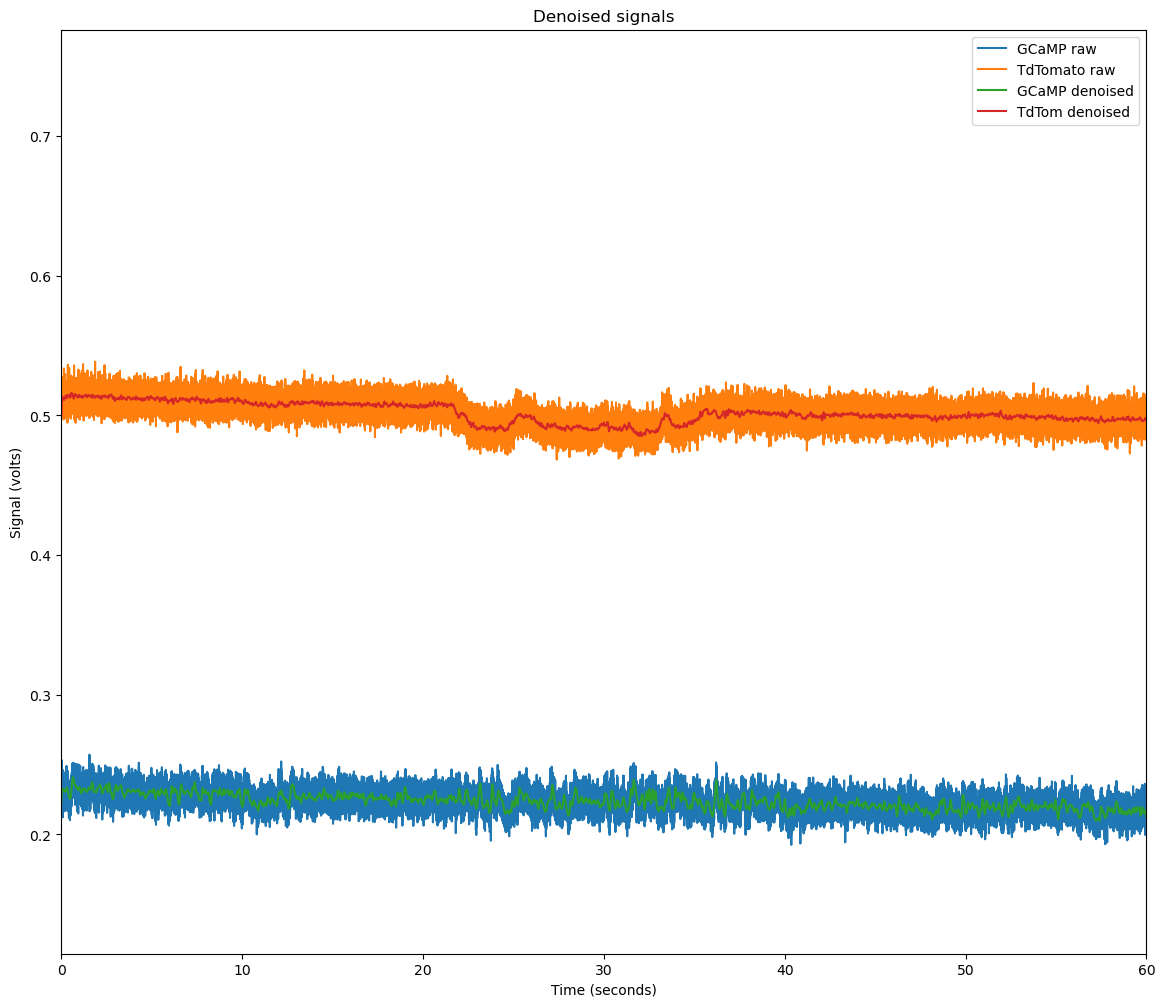

In [32]:
plt.plot(time_seconds, GCaMP_raw, label='GCaMP raw')
plt.plot(time_seconds, TdTom_raw, label='TdTomato raw')
plt.plot(time_seconds, GCaMP_denoised, label='GCaMP denoised')
plt.plot(time_seconds, TdTom_denoised, label='TdTom denoised') 
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Denoised signals')
plt.legend()
plt.xlim(0,60)
# plt.ylim(1,1.4);

# Photobleaching correction

Now lets compare some different ways of removing the influence of photobleaching.

A simple way to remove slow changes is simply to highpass filter the signal with a very low cutoff frequency. Here we will high pass at 0.001Hz, which correponds to a period of 16 minutes.  All components of the signal changing on a slower timescale than this will be removed, which removes the drift due to bleaching, but will also remove any physiological variation in the signal on very slow timescales.

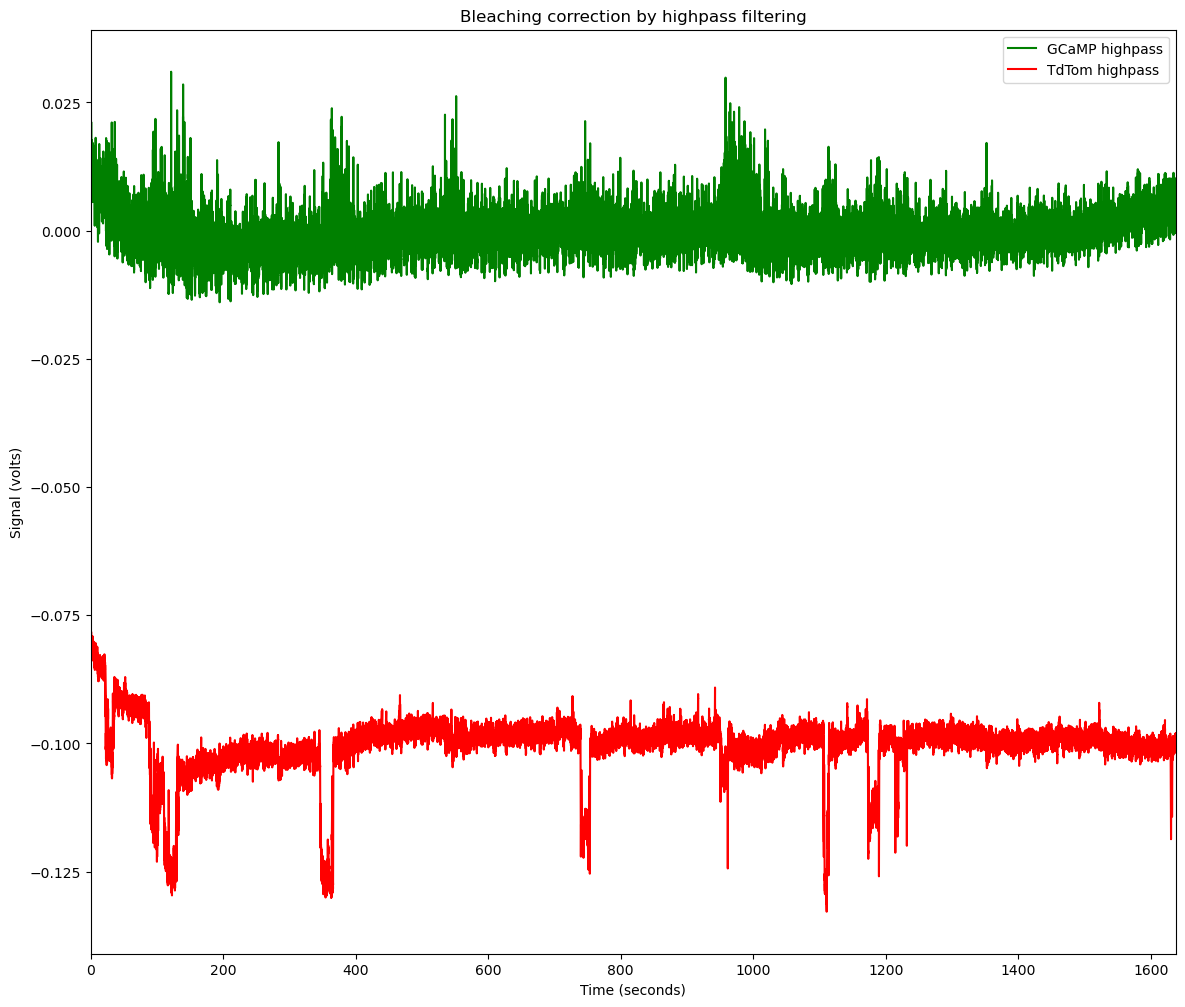

In [33]:
b,a = butter(2, 0.001, btype='high', fs=sampling_rate)
GCaMP_highpass = filtfilt(b,a, GCaMP_denoised, padtype='even')
TdTom_highpass = filtfilt(b,a, TdTom_denoised, padtype='even')

plt.plot(time_seconds, GCaMP_highpass    ,'g', label='GCaMP highpass')
plt.plot(time_seconds, TdTom_highpass-0.1,'r', label='TdTom highpass')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Bleaching correction by highpass filtering')
plt.legend();

Annother possible way of removing the influence of bleaching is to fit an exponential decay to the data and subtract this exponential fit from the signal.

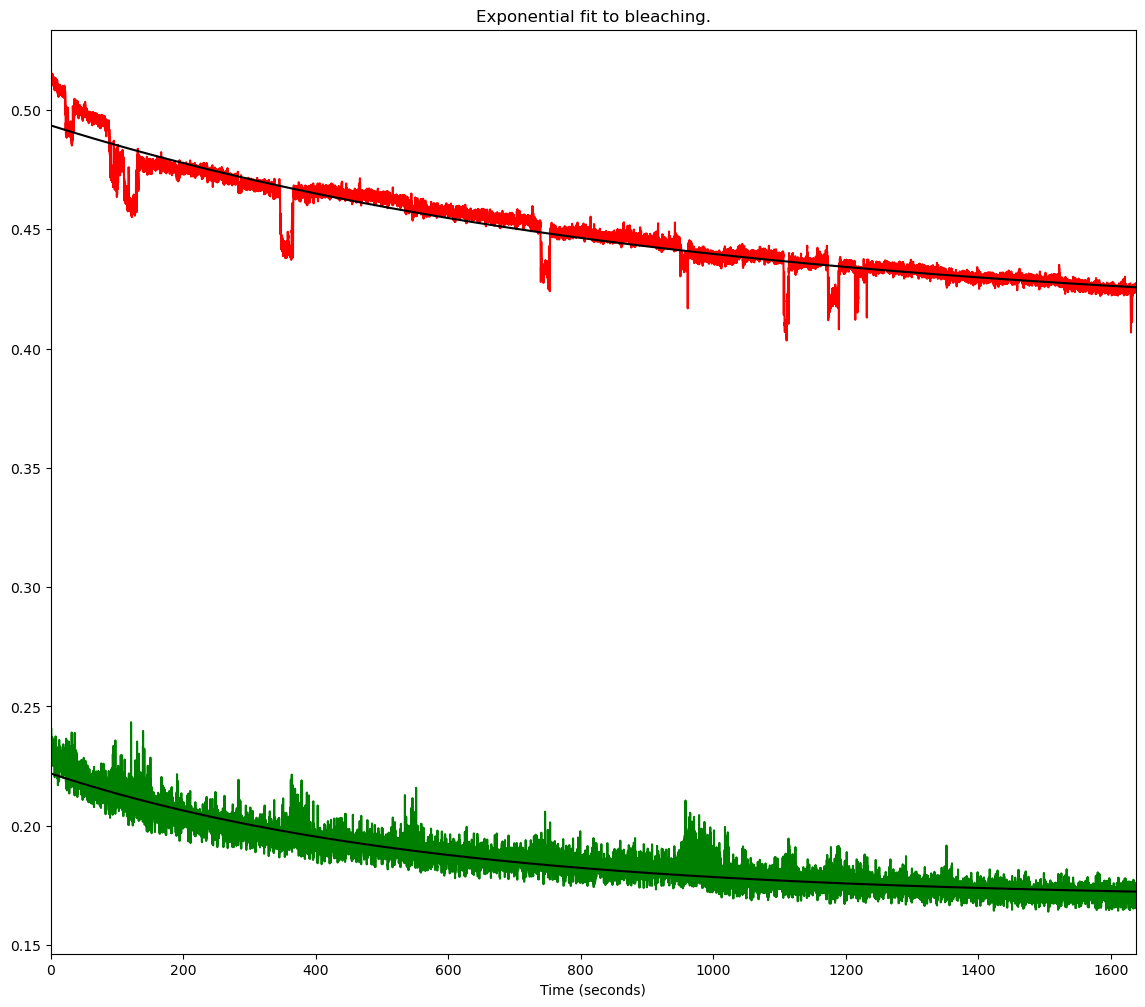

In [34]:
# The exponential curve we are going to fit.
def exp_func(x, a, b, c):
   return a*np.exp(-b*x) + c

# Fit curve to GCaMP signal.
GCaMP_parms, parm_cov = curve_fit(exp_func, time_seconds, GCaMP_denoised, p0=[1,1e-3,1],bounds=([0,0,0],[4,0.1,4]), maxfev=1000)
GCaMP_expfit = exp_func(time_seconds, *GCaMP_parms)

# Fit curve to TdTomato signal.
TdTom_parms, parm_cov = curve_fit(exp_func, time_seconds, TdTom_denoised, p0=[1,1e-3,1],bounds=([0,0,0],[4,0.1,4]), maxfev=1000)
TdTom_expfit = exp_func(time_seconds, *TdTom_parms)

plt.plot(time_seconds, GCaMP_denoised, 'g', label='GCaMP')
plt.plot(time_seconds, GCaMP_expfit,'k', linewidth=1.5) 
plt.plot(time_seconds, TdTom_denoised, 'r', label='TdTomato')
plt.plot(time_seconds, TdTom_expfit,'k', linewidth=1.5) 
plt.title('Exponential fit to bleaching.')
plt.xlabel('Time (seconds)');

Now subtract the exponential fits from the signals.

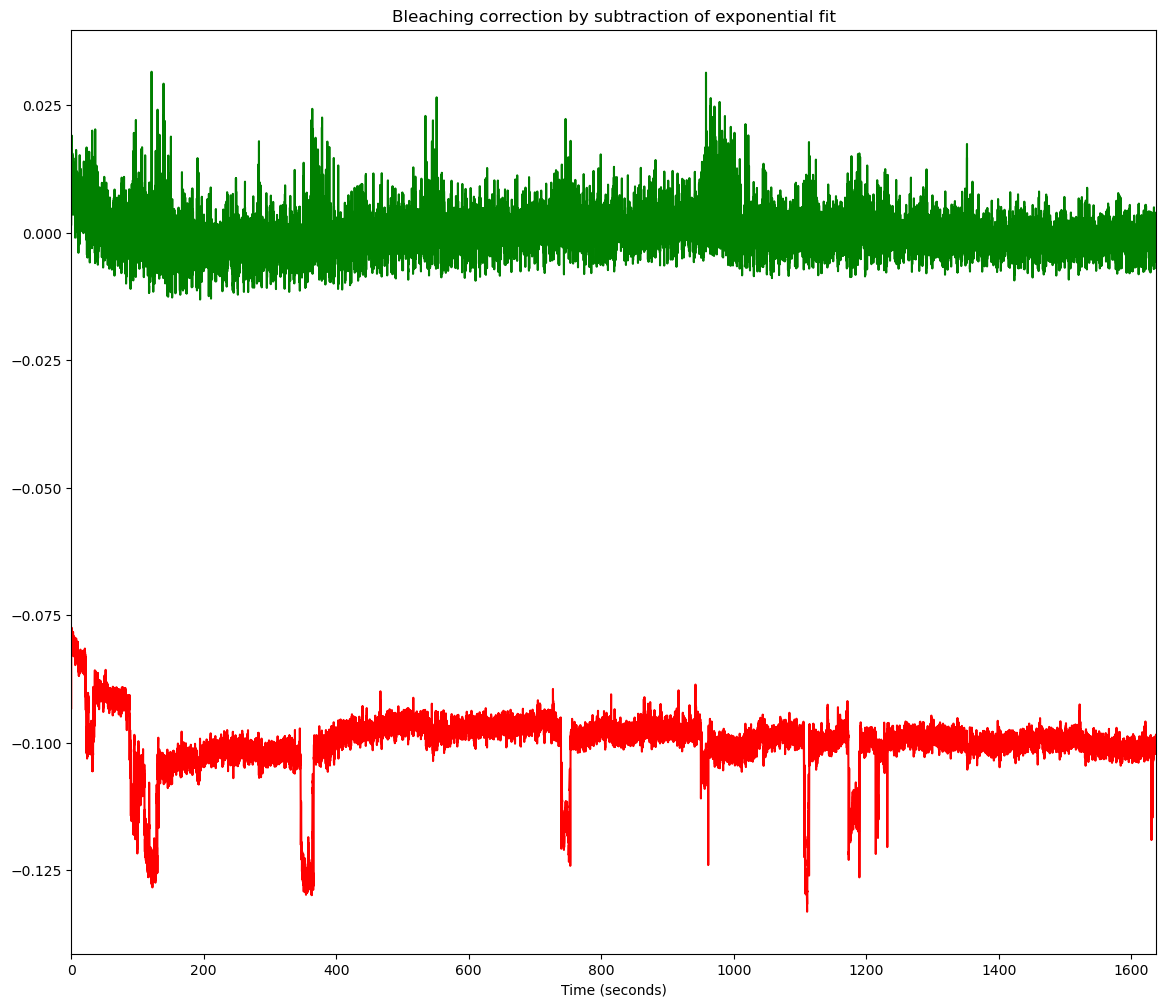

In [35]:
GCaMP_es = GCaMP_denoised - GCaMP_expfit
TdTom_es = TdTom_denoised - TdTom_expfit

plt.plot(time_seconds, GCaMP_es    , 'g', label='GCaMP')
plt.plot(time_seconds, TdTom_es-0.1, 'r', label='TdTomato')
plt.title('Bleaching correction by subtraction of exponential fit')
plt.xlabel('Time (seconds)');

Annother possibility for bleaching correction is to subtract a low order polynomial fit rather than an exponential.  This allows for more degrees of freedom in the slow component that is removed than fitting an exponential but less than highpass filtering. 

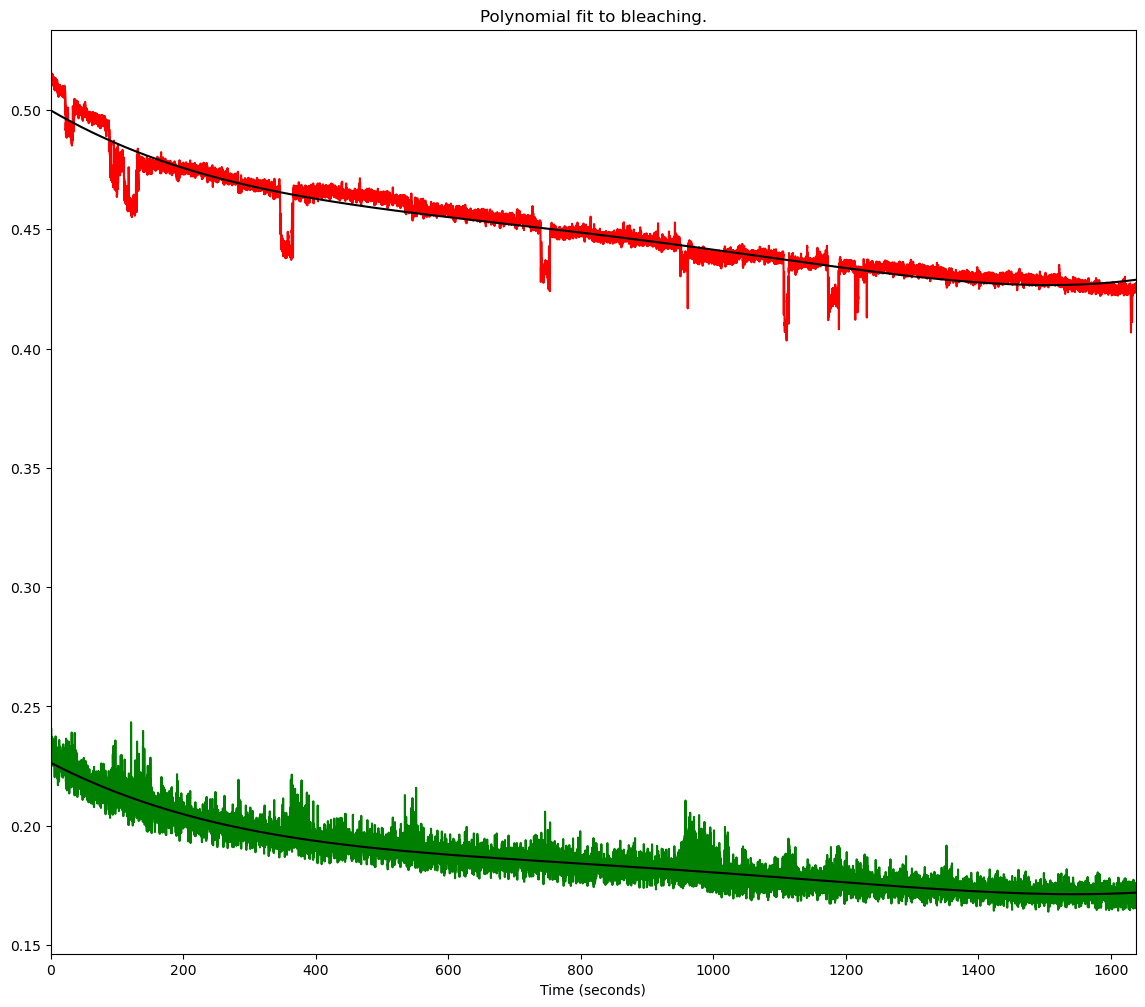

In [36]:
# Fit 4th order polynomial to GCaMP signal.
coefs_GCaMP = np.polyfit(time_seconds, GCaMP_denoised, deg=4)
GCaMP_polyfit = np.polyval(coefs_GCaMP, time_seconds)

# Fit 4th order polynomial to TdTomato signal.
coefs_TdTom = np.polyfit(time_seconds, TdTom_denoised, deg=4)
TdTom_polyfit = np.polyval(coefs_TdTom, time_seconds)

# Plot fits
plt.plot(time_seconds, GCaMP_denoised, 'g', label='GCaMP')
plt.plot(time_seconds, GCaMP_polyfit,'k', linewidth=1.5) 
plt.plot(time_seconds, TdTom_denoised, 'r', label='TdTomato')
plt.plot(time_seconds, TdTom_polyfit,'k', linewidth=1.5) 
plt.title('Polynomial fit to bleaching.')
plt.xlabel('Time (seconds)');

Subtract the polynomial fit from the signals.

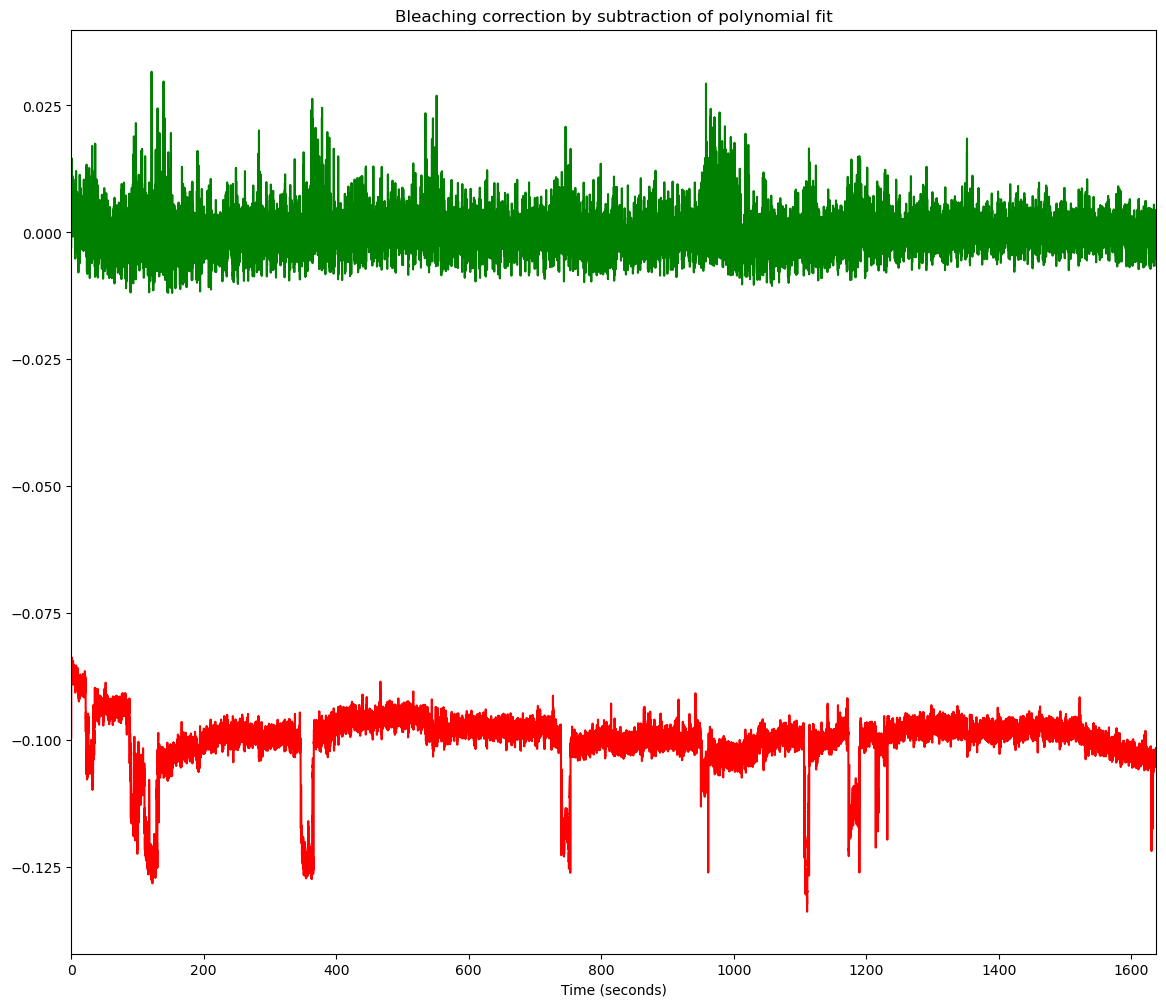

In [37]:
GCaMP_ps = GCaMP_denoised - GCaMP_polyfit
TdTom_ps = TdTom_denoised - TdTom_polyfit

plt.plot(time_seconds, GCaMP_ps    , 'g', label='GCaMP')
plt.plot(time_seconds, TdTom_ps-0.1, 'r', label='TdTomato')
plt.title('Bleaching correction by subtraction of polynomial fit')
plt.xlabel('Time (seconds)');

# Motion correction

We now do motion correction by finding the best linear fit of the TdTomato signal to the GCaMP signal and subtracting this estimated motion component from the GCaMP signal.  We will use the data that was bleaching corrected with highpass filtering for the following steps.

Slope    : 0.113
R-squared: 0.027


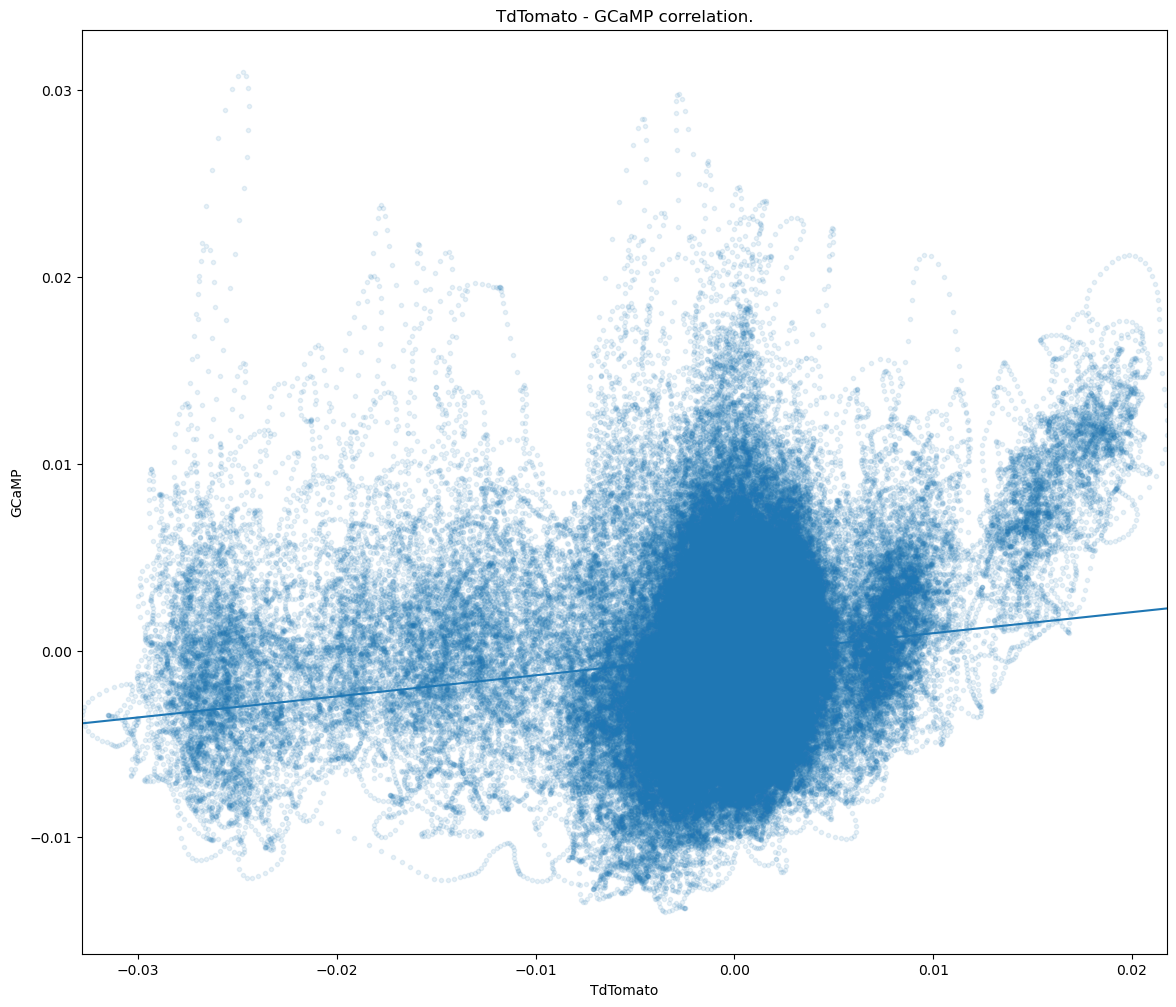

In [38]:
slope, intercept, r_value, p_value, std_err = linregress(x=TdTom_highpass, y=GCaMP_highpass)

plt.scatter(TdTom_highpass[::5], GCaMP_highpass[::5],alpha=0.1, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x)
plt.xlabel('TdTomato')
plt.ylabel('GCaMP')
plt.title('TdTomato - GCaMP correlation.')

print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))

Calculate the estimated motion component of the GCaMP signal and subtract to get motion corrected signal.

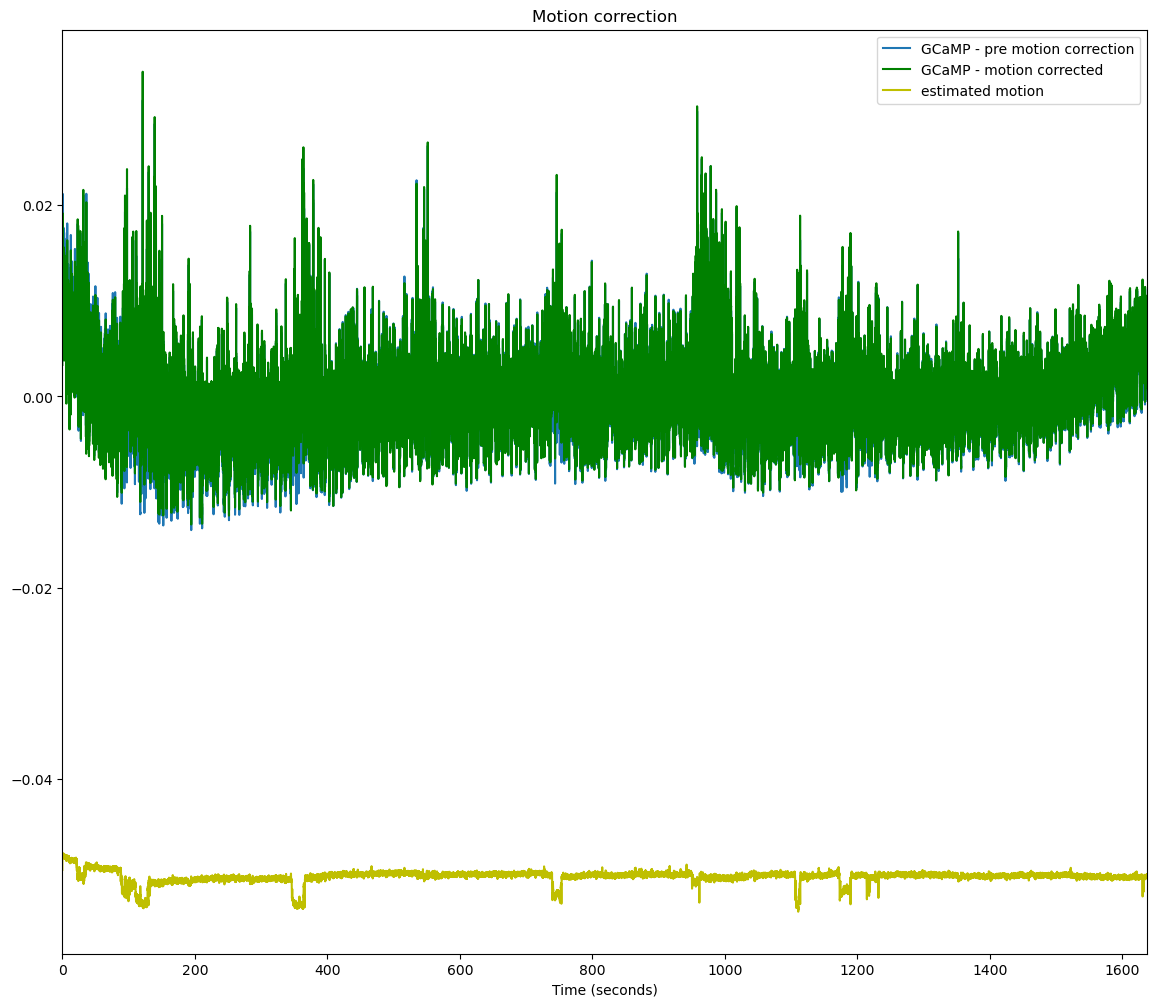

In [39]:
GCaMP_est_motion = intercept + slope * TdTom_highpass
GCaMP_corrected = GCaMP_highpass - GCaMP_est_motion

plt.plot(time_seconds, GCaMP_highpass  , label='GCaMP - pre motion correction')
plt.plot(time_seconds, GCaMP_corrected, 'g', label='GCaMP - motion corrected')
plt.plot(time_seconds, GCaMP_est_motion - 0.05, 'y', label='estimated motion')
plt.xlabel('Time (seconds)')
plt.title('Motion correction')
plt.legend()
# plt.xlim(0,180);

# dF/F

Convert the motion corrected signal into dF/F.  The dF is just the motion corrected signal plotted above.  The baseline fluorescence F changes over the course of the session due to photobleaching.  We estimate F as a function of session time by lowpass filtering the GCaMP signal with a very low (0.001Hz) cutoff frequency.

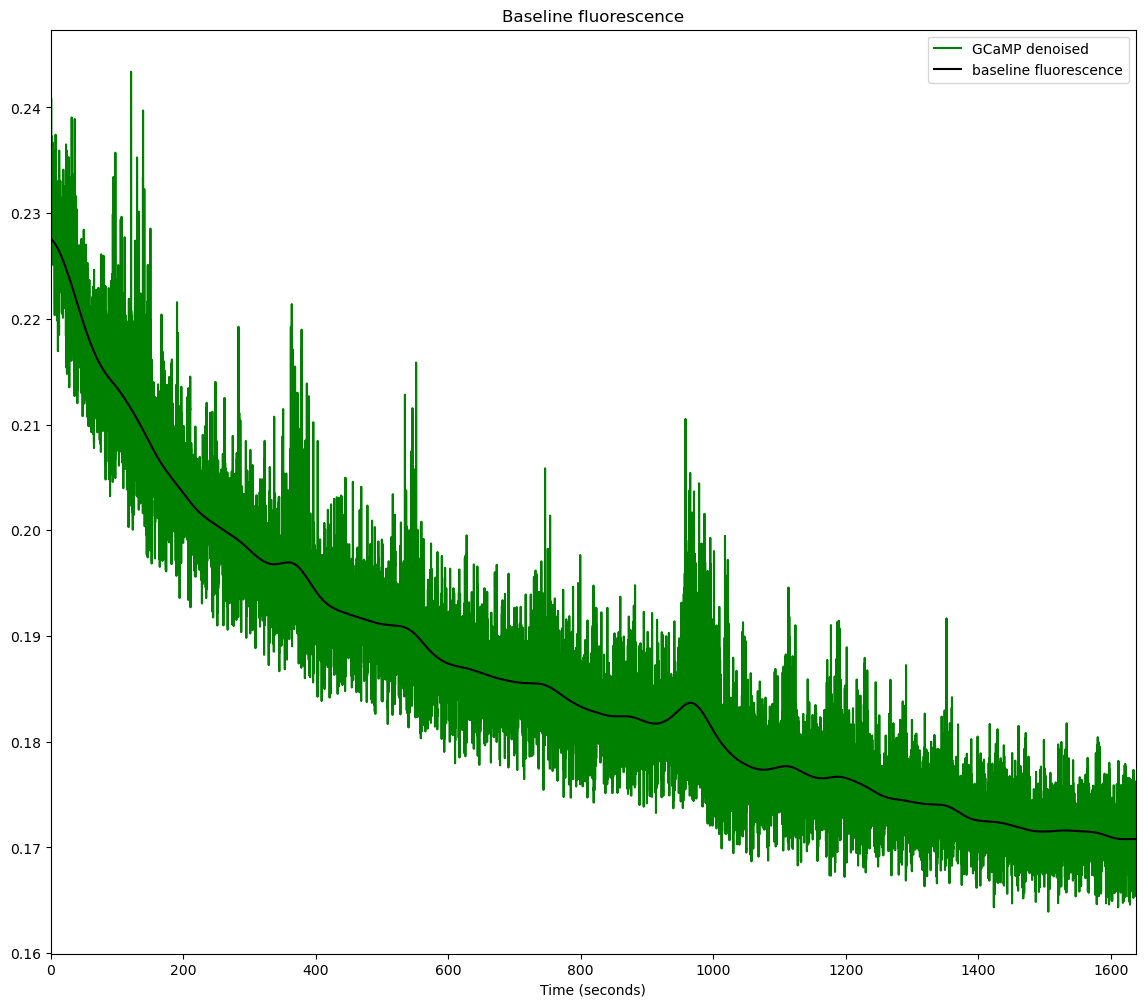

In [48]:
b,a = butter(2, 0.01, btype='low', fs=sampling_rate)
baseline_fluorescence = filtfilt(b,a, GCaMP_denoised, padtype='even')

plt.plot(time_seconds, GCaMP_denoised       , 'g', label='GCaMP denoised')
plt.plot(time_seconds, baseline_fluorescence, 'k', label='baseline fluorescence')
plt.xlabel('Time (seconds)')
plt.title('Baseline fluorescence')
plt.legend();

Now calculate the dF/F by dividing the motion corrected signal by the time varying baseline fluorescence.

Text(0.5, 1.0, 'GCaMP dF/F')

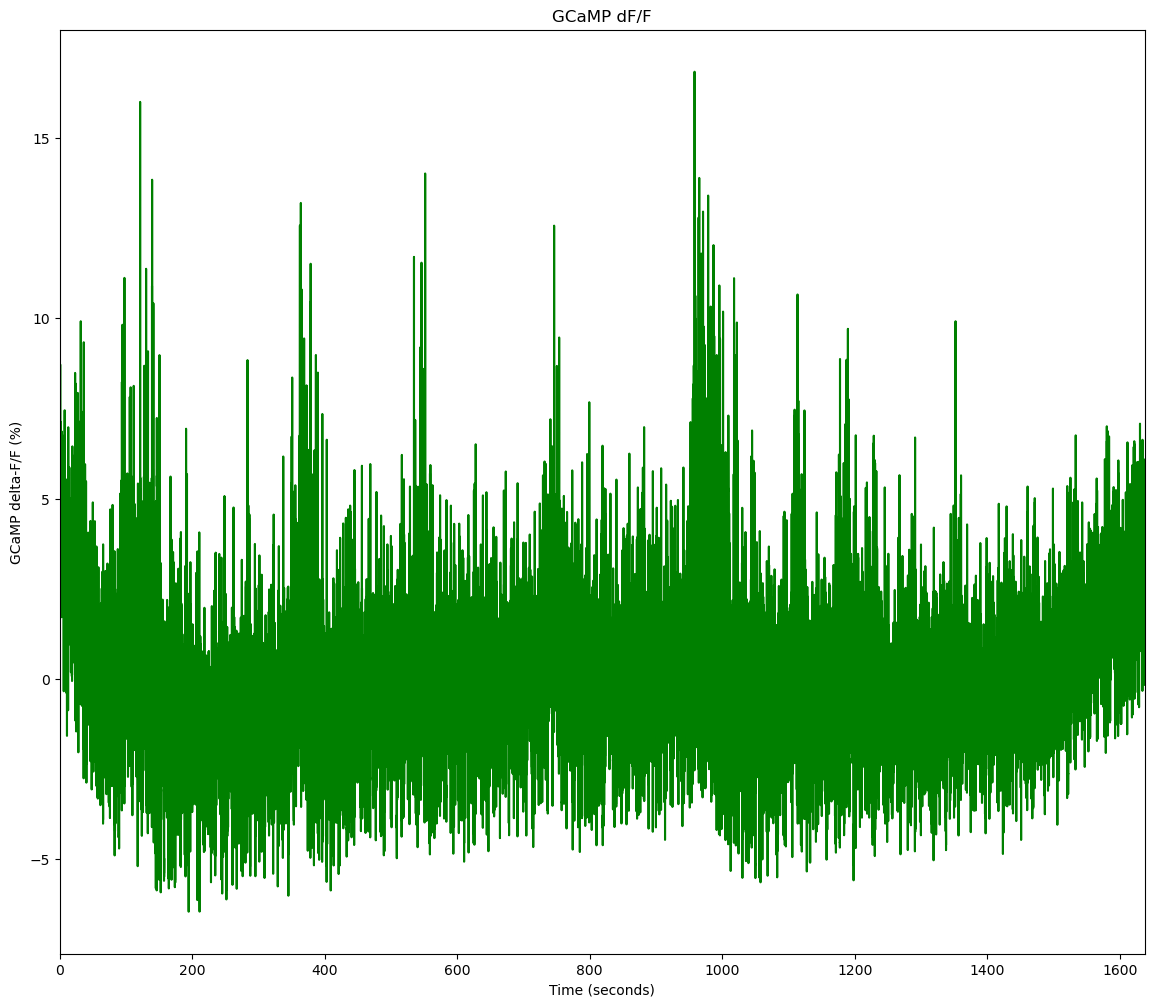

In [41]:
GCaMP_dF_F = GCaMP_corrected/baseline_fluorescence

plt.plot(time_seconds, GCaMP_dF_F*100, 'g')
plt.xlabel('Time (seconds)')
plt.ylabel('GCaMP delta-F/F (%)')
plt.title('GCaMP dF/F')
# plt.xlim(0,180);

(c) Copyright Thomas Akam 2019

In [42]:
# allow for automatic reloading of classes and function when updating the code
%load_ext autoreload
%autoreload 2 

import pandas as pd
from pathlib import Path

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *

trial_window = [-2000, 4000] # in ms

# time limit around trigger to perform an event
# determine successful trials
# timelim = [1000, 4000] # in ms

# Digital channel nb of the pyphotometry device
# on which rsync signal is sent (from pycontrol device)
rsync_chan = 2

basefolder = Path(os.getcwd()).parent.parent

# These must be absolute paths
# use this to use within package tasks files (in params)
tasksfile = Path(basefolder,'params','tasks_params.csv')
# use this to put a local full path
#tasksfile = -r'C:/.../tasks_params.csv' 

# from sample_data

# # From jade
# photometry_dir = Path('/home/MRC.OX.AC.UK/phar0732/ettin/Data/head-fixed/photometry')
# pycontrol_dir = Path('/home/MRC.OX.AC.UK/phar0732/ettin/Data/head-fixed/pycontrol')

# From julien-pc
# photometry_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\pyphotometry\data\reaching_go_spout_bar_nov22'
# pycontrol_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\pycontrol\reaching_go_spout_bar_nov22'

#From laptop
photometry_dir = r'C:\Users\phar0732\Documents\GitHub\trialexp\sample_data\pyphotometry\reaching_go_spout_incr_break2_nov22'
pycontrol_dir = r'C:\Users\phar0732\Documents\GitHub\trialexp\sample_data\pycontrol\reaching_go_spout_incr_break2_nov22'

video_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\videos'
tasks = pd.read_csv(tasksfile, usecols=[1, 2, 3, 4], index_col=False)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create an experiment object


In [43]:
# Load all raw text sessions in the indicated folder or a sessions.pkl file
# if already existing in folder_path
exp_cohort = Experiment(path=pycontrol_dir, int_subject_IDs=True, update=True, verbose=True)

Saved sessions loaded from: sessions.pkl
session nb:  1 58 2023-02-06 10:41:32 reaching_go_spout_incr_break2_nov22
session nb:  2 58 2023-02-07 10:54:30 reaching_go_spout_incr_break2_nov22
session nb:  3 58 2023-02-08 10:18:04 reaching_go_spout_incr_break2_nov22
session nb:  4 58 2023-02-09 11:42:16 reaching_go_spout_incr_break2_nov22
session nb:  5 58 2023-02-10 11:35:33 reaching_go_spout_incr_break2_nov22
session nb:  1 60 2023-02-07 13:06:37 reaching_go_spout_incr_break2_nov22
session nb:  2 60 2023-02-08 14:03:21 reaching_go_spout_incr_break2_nov22
session nb:  3 60 2023-02-09 11:47:15 reaching_go_spout_incr_break2_nov22
session nb:  4 60 2023-02-09 12:16:53 reaching_go_spout_incr_break2_nov22
session nb:  5 60 2023-02-10 10:51:38 reaching_go_spout_incr_break2_nov22
session nb:  6 60 2023-02-10 10:52:56 reaching_go_spout_incr_break2_nov22
session nb:  7 60 2023-02-10 10:54:16 reaching_go_spout_incr_break2_nov22
session nb:  8 60 2023-02-10 11:03:16 reaching_go_spout_incr_break2_nov

In [44]:
exp_cohort.sessions = [session for session in exp_cohort.sessions if (session.subject_ID > 50)]

### Perform extraction of behavioural information by trial

In [45]:
# Process the whole experimental folder by trials

trial_window = [-4000,6000]
exp_cohort.process_exp_by_trial(trial_window, timelim=None, tasksfile=tasksfile, verbose=True)

# Save the file as sessions.pkl in folder_path
# exp_cohort.save()

processing by trial: kms061-2023-02-06-103133.txt task: reaching_go_spout_incr_break2_nov22
processing by trial: kms058-2023-02-06-104132.txt task: reaching_go_spout_incr_break2_nov22
processing by trial: kms063-2023-02-06-110950.txt task: reaching_go_spout_incr_break2_nov22
processing by trial: kms062-2023-02-06-112913.txt task: reaching_go_spout_incr_break2_nov22
processing by trial: kms058-2023-02-07-105430.txt task: reaching_go_spout_incr_break2_nov22
processing by trial: kms062-2023-02-07-115221.txt task: reaching_go_spout_incr_break2_nov22
processing by trial: kms063-2023-02-07-121350.txt task: reaching_go_spout_incr_break2_nov22
processing by trial: kms060-2023-02-07-130637.txt task: reaching_go_spout_incr_break2_nov22
processing by trial: kms058-2023-02-08-101804.txt task: reaching_go_spout_incr_break2_nov22
processing by trial: kms061-2023-02-08-135720.txt task: reaching_go_spout_incr_break2_nov22
processing by trial: kms060-2023-02-08-140321.txt task: reaching_go_spout_incr_b

In [46]:
exp_cohort.match_sessions_to_files(files_dir=photometry_dir, ext='ppd', verbose=True)

61 2023-02-06 10:31:33 ['kms061-2023-02-06-103130.ppd']
58 2023-02-06 10:41:32 []
63 2023-02-06 11:09:50 ['kms063-2023-02-06-110946.ppd']
62 2023-02-06 11:29:13 []
58 2023-02-07 10:54:30 ['kms058-2023-02-07-105427.ppd']
62 2023-02-07 11:52:21 ['kms062-2023-02-07-115210.ppd']
63 2023-02-07 12:13:50 ['kms063-2023-02-07-121347.ppd']
60 2023-02-07 13:06:37 ['kms060-2023-02-07-130629.ppd']
58 2023-02-08 10:18:04 ['kms058-2023-02-08-101802.ppd']
61 2023-02-08 13:57:20 []
60 2023-02-08 14:03:21 ['kms060-2023-02-08-140319.ppd']
63 2023-02-08 14:48:36 []
61 2023-02-09 10:52:13 ['kms061-2023-02-09-105209.ppd']
58 2023-02-09 11:42:16 ['kms058-2023-02-09-114215.ppd']
60 2023-02-09 11:47:15 ['kms060-2023-02-09-114659.ppd']
60 2023-02-09 12:16:53 ['kms060-2023-02-09-121646.ppd']
61 2023-02-10 10:18:22 []
60 2023-02-10 10:54:16 []
60 2023-02-10 11:03:16 []
58 2023-02-10 11:35:33 []


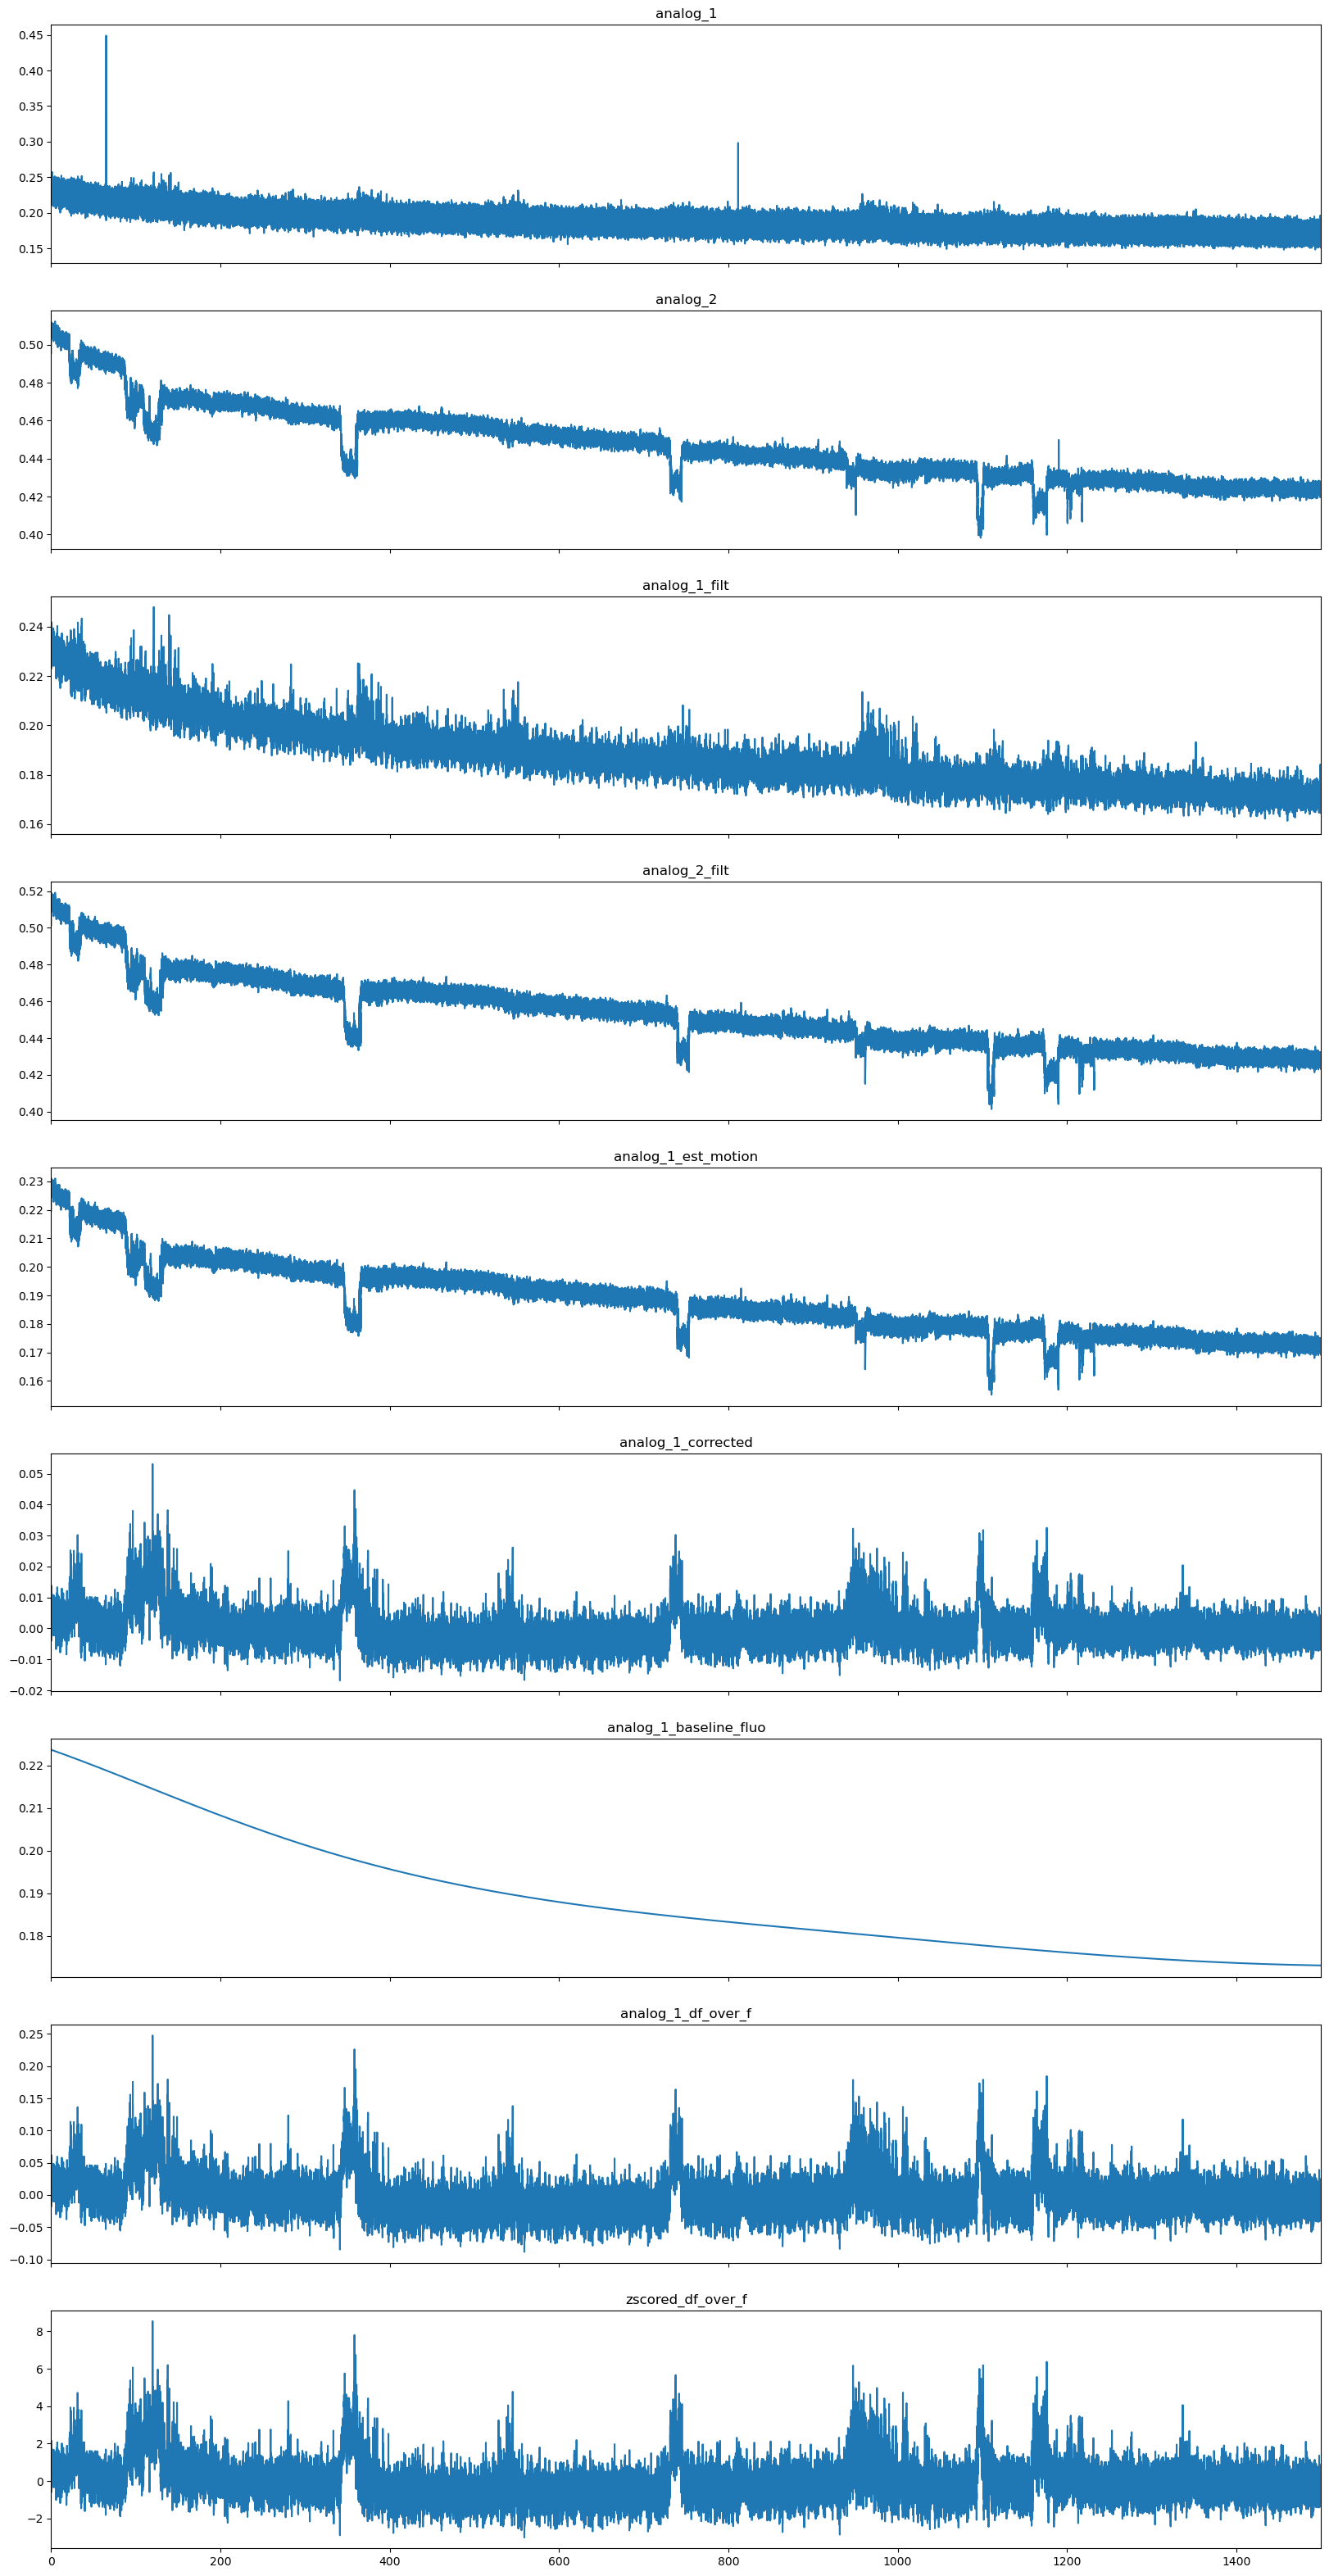

In [47]:
from scipy.signal import decimate
from trialexp.process.pyphotometry.photometry_functional import get_photometry_trials


# sessions = [session for session in exp_cohort_mixed.sessions if (session.subject_ID == 64 and session.datetime.date() == datetime(2023,2,23).date()) ]

df_meta_photo, col_names_numpy, photo_array, photometry_dict = get_photometry_trials(
    exp_cohort.sessions[0],
    conditions_list = None,
    cond_aliases = None,
    trial_window = [-4000,6000],
    trig_on_ev = None,
    last_before = None,
    baseline_low_pass = 0.001, 
    low_pass = 45, 
    median_filt = 5, 
    motion_corr = True, 
    df_over_f = True,
    z_score = True, # To be implemented
    downsampling_factor = 10,
    return_full_session = True, 
    export_vars = ['analog_2','analog_1_df_over_f','analog_1_corrected'],
    verbose = False)

photometry_dict.keys()


vars_to_plot = ['analog_1', 'analog_2', 'analog_1_filt', 'analog_2_filt','analog_1_est_motion', 'analog_1_corrected', 'analog_1_baseline_fluo', 'analog_1_df_over_f', 'zscored_df_over_f']

figsize = (20,40)
x_lim = [0, 1500]
fig, axs = plt.subplots(len(vars_to_plot),1, figsize = figsize, sharex=True)
for l, v in enumerate(vars_to_plot):
    # print(len(photometry_dict[v]) , len(photometry_dict['time']))
    if len(photometry_dict[v]) < len(photometry_dict['time']):
        axs[l].plot(decimate(photometry_dict['time'],10)/1000, photometry_dict[v])
    else:
        axs[l].plot(photometry_dict['time']/1000, photometry_dict[v])
    axs[l].set_title(v)
    axs[l].set_xlim(x_lim)